### Reference
* https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/code?competitionId=10170&sortBy=voteCount
* https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters
* https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
* https://www.kaggle.com/shaz13/simple-exploration-notebook-map-plots-v2 [plotly]
* https://www.kaggle.com/dimitreoliveira/tensorflow-dnn-coursera-ml-course-tutorial [这个里面 data preprocessing 特别好]
* https://www.kaggle.com/willkoehrsen/a-walkthrough-and-a-challenge [这个总结的不错， 有 grid search tuning]

### Use a mini data, the raw train data is > 5GB

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn

In [51]:
# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

# plt.style.use('fivethirtyeight')
# plt.rcParams['font.size'] = 18

import seaborn as sns
palette = sns.color_palette('Paired', 10)

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# Set random seed 
RSEED = 100

In [5]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

In [6]:
train = pd.read_csv("datasets/train_mini.csv")
test = pd.read_csv("datasets/test.csv")

print(train.shape, test.shape)

(1000000, 8) (9914, 7)


In [7]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 202.8 MB


### Memory
One more thing we can do - change the type of numeric values to subtypes that consumers less memory. For Eg : passenger_count's type is int64, which takes 8 bytes and we know that maximum one digint (non-negative) is going to get stored here for which uint is enough.

In [9]:
train.passenger_count = train.passenger_count.astype(dtype = 'uint8')
train.pickup_longitude = train.pickup_longitude.astype(dtype = 'float32')
train.pickup_latitude = train.pickup_latitude.astype(dtype = 'float32')
train.dropoff_longitude = train.dropoff_longitude.astype(dtype = 'float32')
train.dropoff_latitude = train.dropoff_latitude.astype(dtype = 'float32')
train.fare_amount = train.fare_amount.astype(dtype = 'float32')

In [10]:
for dtype in ['float','int','object']:
    selected_dtype = train.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 0.00 MB
Average memory usage for int columns: 0.00 MB
Average memory usage for object columns: 52.35 MB


## EDA and data processing

Text(0.5, 1.0, 'Fare Binned')

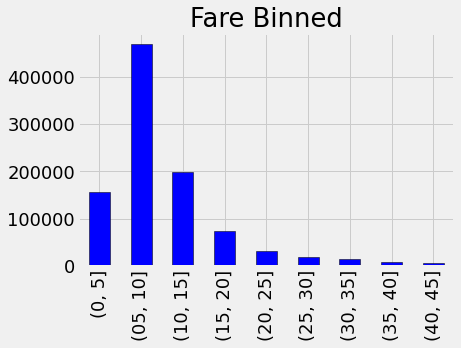

In [11]:
# Bin the fare and convert to string
train['fare-bin'] = pd.cut(train['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
train.loc[train['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
train.loc[train['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
train['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned')

2.1601226


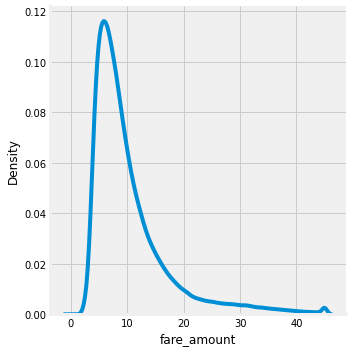

In [63]:
sns.displot(data=train.fare_amount, kind="kde")
print(train['fare_amount'].skew())

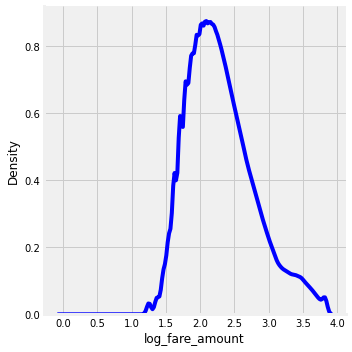

In [65]:
train['log_fare_amount'] = np.log1p(train['fare_amount'])
sns.displot(data=train['log_fare_amount'], color='blue', kind="kde")

In [67]:
k = np.log1p(100)
print(k)
print(np.expm1(k))

4.61512051684126
100.00000000000003


In [12]:
# Create a color mapping based on fare bins
color_mapping = {fare_bin: palette[i] for i, fare_bin in enumerate(train['fare-bin'].unique())}
color_mapping

{'(0, 5]': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 '(15, 20]': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 '(05, 10]': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 '(10, 15]': (0.2, 0.6274509803921569, 0.17254901960784313),
 '(20, 25]': (0.984313725490196, 0.6039215686274509, 0.6),
 '(30, 35]': (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 nan: (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 '(25, 30]': (1.0, 0.4980392156862745, 0.0),
 '(35, 40]': (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 '(40, 45]': (0.41568627450980394, 0.23921568627450981, 0.6039215686274509)}

In [13]:
train['color'] = train['fare-bin'].map(color_mapping)

#### Empirical Cumulative Distribution Function Plot
Another plot for showing the distribution of a single variable is the empirical cumulative distribution function. This shows the percentile on the y-axis and the variable on the x-axis and gets around some of the issues associated with binning data for histograms or the kernel width of the KDE.

In [14]:
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

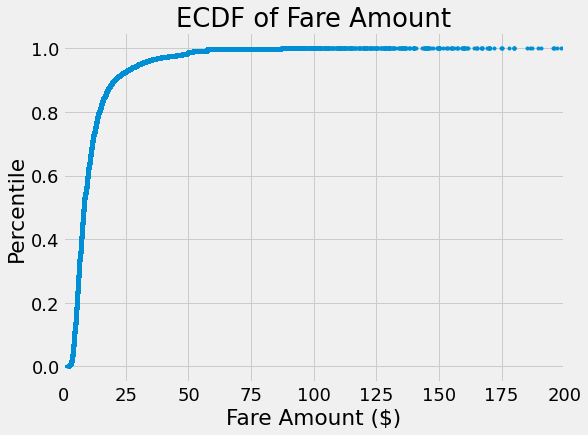

In [15]:
xs, ys = ecdf(train['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs, ys, '.')
plt.xlim(0, 200)
# plt.ylim(0,1)
plt.ylabel('Percentile'); plt.title('ECDF of Fare Amount'); plt.xlabel('Fare Amount ($)');

In [16]:
#check for missing values in train data
train.isnull().sum().sort_values(ascending=False)

fare-bin             20830
dropoff_longitude       10
dropoff_latitude        10
key                      0
fare_amount              0
pickup_datetime          0
pickup_longitude         0
pickup_latitude          0
passenger_count          0
color                    0
dtype: int64

In [17]:
#drop the missing values
train = train.drop(train[train.isnull().any(1)].index, axis = 0)

Quick Googling gave me this info

* Latitudes range from -90 to 90.
* Longitudes range from -180 to 180.

In [19]:
# train[train['pickup_latitude']<-90]

In [20]:
# train[train['pickup_latitude']>90]

In [21]:
def clean(df):
    # Delimiter lats and lons to NY only
    df = df[(-76 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72)]
    df = df[(-76 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72)]
    df = df[(38 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 42)]
    df = df[(38 <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 42)]
    # Remove possible outliers
    df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 250)]
    # Remove inconsistent values
    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df

## Feature engineering

* https://www.kaggle.com/dimitreoliveira/taxi-fare-prediction-with-keras-deep-learning
* https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters


*  Now i'll do some feature engineering and process the data, i'm basically creating 3 kinds of features.
    *  **Time features**
        * Year, Month, Day, Hour, Weekday
        * Night (between 16h and 20h, from monday to friday)
        * Late night (between 20h and and 6h)
    * **Coordinate features**
        * Latitude difference (difference from pickup and dropout latitudes)
        * Longitude difference (difference from pickup and dropout longitudes)
    * **Distances features**
        * Euclidean (Euclidean distance from pickup and dropout)
        * Manhattan (Manhattan distance from pickup and dropout)
        * Manhattan distances from pickup location and downtown, JFK, EWR and LGR airports (see if the ride started at one of these locations).
        * Manhattan distances from dropout location and downtown, JFK, EWR and LGR airports (see if the ride ended at one of these locations).

We can calulate the distance in a sphere when latitudes and longitudes are given by [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)

**haversine(θ) = sin²(θ/2)**

Eventually, the formual boils down to the following where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km) to include latitude and longitude coordinates (A and B in this case).

**a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)**

**c = 2 * atan2( √a, √(1−a) )**

**d = R ⋅ c**

**d = Haversine distance**

*Refer [this](https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula) page for more info and examples on Haversine formula*

In [22]:
def late_night (row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0


def night (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0
    
    
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)


def add_time_features(df):
#     df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'])
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['pickup_datetime'] =  df['pickup_datetime'].apply(lambda x: str(x))
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    # Drop 'pickup_datetime' as we won't need it anymore
    df = df.drop('pickup_datetime', axis=1)
    
    return df


def add_coordinate_features(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    # Add new features
    df['latdiff'] = (lat1 - lat2)
    df['londiff'] = (lon1 - lon2)

    return df


def add_distances_features(df):
    # Add distances from airpot and downtown
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    df['euclidean'] = (df['latdiff'] ** 2 + df['londiff'] ** 2) ** 0.5
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)
    
    df['downtown_pickup_distance'] = manhattan(ny[1], ny[0], lat1, lon1)
    df['downtown_dropoff_distance'] = manhattan(ny[1], ny[0], lat2, lon2)
    df['jfk_pickup_distance'] = manhattan(jfk[1], jfk[0], lat1, lon1)
    df['jfk_dropoff_distance'] = manhattan(jfk[1], jfk[0], lat2, lon2)
    df['ewr_pickup_distance'] = manhattan(ewr[1], ewr[0], lat1, lon1)
    df['ewr_dropoff_distance'] = manhattan(ewr[1], ewr[0], lat2, lon2)
    df['lgr_pickup_distance'] = manhattan(lgr[1], lgr[0], lat1, lon1)
    df['lgr_dropoff_distance'] = manhattan(lgr[1], lgr[0], lat2, lon2)
    
    return df


def haversine_distance(df, lat1, long1, lat2, long2):
    R = 6371  #radius of earth in kilometers
    #R = 3959 #radius of earth in miles
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])

    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])

    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2

    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    #d = R*c
    d = (R * c) #in kilometers
    df['haversine_distance'] = d
    return df

In [28]:
%%time
train = clean(train)

train = add_time_features(train)
test = add_time_features(test)

add_coordinate_features(train)
add_coordinate_features(test)

train = add_distances_features(train)
test = add_distances_features(test)

train = haversine_distance(train, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
test = haversine_distance(test, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

Wall time: 28.5 s


In [29]:
train.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,color,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance,haversine_distance
0,2009-06-15 17:26:21.0000001,4.5,-73.844315,40.721317,-73.841614,40.712276,1,"(0, 5]","(0.6509803921568628, 0.807843137254902, 0.8901...",2009,6,15,17,0,1,0,0.009041,-0.002701,0.009436,0.011742,0.169220,0.166664,0.139248,0.127506,0.362007,0.355667,0.074371,0.086113,1.030742
1,2010-01-05 16:52:16.0000002,16.9,-74.016045,40.711304,-73.979271,40.782005,1,"(15, 20]","(0.12156862745098039, 0.47058823529411764, 0.7...",2010,1,5,16,1,1,0,-0.070702,-0.036774,0.079693,0.107475,0.012524,0.094952,0.300964,0.334892,0.180264,0.287739,0.204739,0.121273,8.450000
2,2011-08-18 00:35:00.00000049,5.7,-73.982735,40.761269,-73.991241,40.750561,2,"(05, 10]","(0.6980392156862745, 0.8745098039215686, 0.541...",2011,8,18,0,3,0,1,0.010708,0.008507,0.013676,0.019215,0.070751,0.051537,0.317619,0.315418,0.263538,0.244324,0.121464,0.140678,1.389632
3,2012-04-21 04:30:42.0000001,7.7,-73.987129,40.733143,-73.991570,40.758091,1,"(05, 10]","(0.6980392156862745, 0.8745098039215686, 0.541...",2012,4,21,4,5,0,1,-0.024948,0.004440,0.025340,0.029388,0.038231,0.058739,0.293888,0.323277,0.231018,0.251526,0.153984,0.133476,2.799211
4,2010-03-09 07:51:00.000000135,5.3,-73.968094,40.768009,-73.956657,40.783764,1,"(05, 10]","(0.6980392156862745, 0.8745098039215686, 0.541...",2010,3,9,7,1,0,0,-0.015755,-0.011436,0.019468,0.027191,0.092133,0.119324,0.309719,0.314037,0.284920,0.312111,0.100082,0.100418,1.999081


In [30]:
train.columns

Index(['key', 'fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare-bin', 'color', 'year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night', 'latdiff', 'londiff', 'euclidean', 'manhattan', 'downtown_pickup_distance', 'downtown_dropoff_distance', 'jfk_pickup_distance', 'jfk_dropoff_distance', 'ewr_pickup_distance', 'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance', 'haversine_distance'], dtype='object')

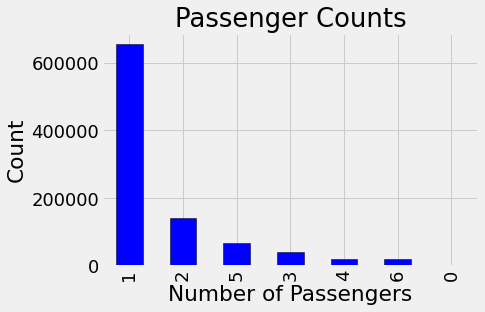

In [31]:
train['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

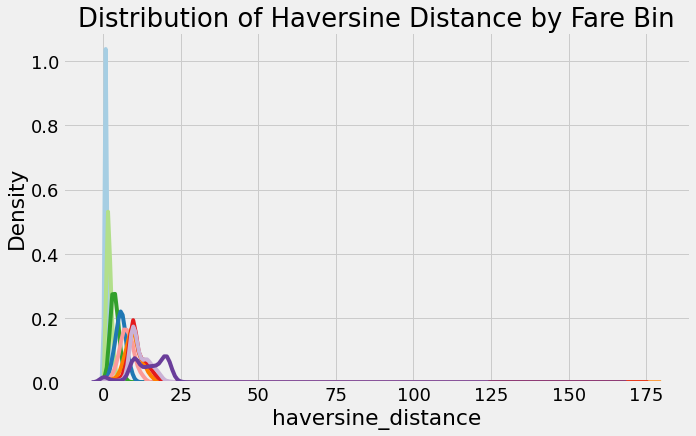

In [32]:
plt.figure(figsize = (10, 6))

for f, grouped in train.groupby('fare-bin'):
    sns.kdeplot(grouped['haversine_distance'], label = f'{f}', color = list(grouped['color'])[0]);
    
plt.title('Distribution of Haversine Distance by Fare Bin');

In [33]:
train.groupby('fare-bin')['haversine_distance'].agg(['mean', 'count'])

,mean,count
fare-bin,,
"(0, 5]",0.944261,148331
"(05, 10]",1.962318,455098
"(10, 15]",3.738972,193785
"(15, 20]",5.612148,71519
"(20, 25]",7.561550,31016
"(25, 30]",9.622839,19474
"(30, 35]",10.798244,14345
"(35, 40]",11.703983,8335
"(40, 45]",14.589603,6520


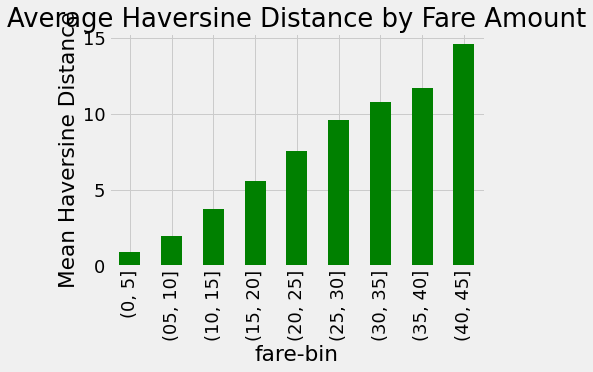

In [34]:
train.groupby('fare-bin')['haversine_distance'].mean().sort_index().plot.bar(color = 'g');
plt.title('Average Haversine Distance by Fare Amount');
plt.ylabel('Mean Haversine Distance');

## Machine Learning

### Create Training and Validation Set
We'll want to create a training and separate validation set to assess our model. Ideally, we only use the test set once, to evaluate the final model. We can make a validation set with 1 million observations to estimate our performance.

We **stratify** the split using the fare-bin. This ensures that the training and validation set have the same distribution of fare bins. This is important for imbalanced classification problems, but it can also be useful for regression problems so we don't end up with a lot of outliers in terms of the target in either the validation or training set. (We have to stratify based on a discrete variable which is why we use the fare bin.)

In [35]:
from sklearn.model_selection import train_test_split

In [166]:
# Since test_dataset is too large, So we are going to keep only 5% of the dataset in test dataset

y = train['fare_amount'].values
# y = train['log_fare_amount'].values
X_train, X_valid, y_train, y_valid = train_test_split(train, y, 
                                                      stratify = train['fare-bin'],
                                                      random_state = RSEED, test_size = 0.05)

In [167]:
X_train.head(3)

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,color,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance,haversine_distance,log_fare_amount
692508,2012-08-26 01:12:14.0000001,6.9,-73.987411,40.720139,-74.003075,40.717091,1,"(05, 10]","(0.6980392156862745, 0.8745098039215686, 0.541...",2012,8,26,1,6,0,1,0.003048,0.015663,0.015957,0.018711,0.024944,0.006233,0.281166,0.293781,0.217731,0.199020,0.167271,0.185982,1.362858,2.066863
141365,2010-01-21 13:39:15.0000001,8.1,-73.975517,40.765377,-73.992149,40.752781,1,"(05, 10]","(0.6980392156862745, 0.8745098039215686, 0.541...",2010,1,21,13,3,0,0,0.012596,0.016632,0.020864,0.029228,0.082077,0.052849,0.314510,0.318546,0.274864,0.245636,0.110138,0.139366,1.980944,2.208274
247420,2011-09-30 21:32:37.0000005,5.7,-73.978699,40.764400,-73.966698,40.752800,0,"(05, 10]","(0.6980392156862745, 0.8745098039215686, 0.541...",2011,9,30,21,4,0,1,0.011600,-0.012001,0.016691,0.023602,0.077919,0.078320,0.316715,0.293114,0.270706,0.271107,0.114296,0.113895,1.638783,1.902107


### Score Model
Here we use the validation set for assessing the model. We'll use two metrics:

Root mean squared error: the metric used by the competition
Mean absolute percentage error: the average percentage error of the predictions
I like using the mean absolute percentage error (MAPE) because it's often more interpretable.

In [173]:
from sklearn.metrics import mean_squared_error

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
        
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

### First Model: Linear Regression

In [174]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [175]:
train.columns

Index(['key', 'fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare-bin', 'color', 'year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night', 'latdiff', 'londiff', 'euclidean', 'manhattan', 'downtown_pickup_distance', 'downtown_dropoff_distance', 'jfk_pickup_distance', 'jfk_dropoff_distance', 'ewr_pickup_distance', 'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance', 'haversine_distance', 'log_fare_amount'], dtype='object')

In [176]:
lr_cols = ['downtown_pickup_distance', 'downtown_dropoff_distance', 'jfk_pickup_distance', 'jfk_dropoff_distance', 
            'ewr_pickup_distance', 'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance',
            'haversine_distance', 'passenger_count']

lr.fit(X_train[lr_cols], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 
      '\tabs_lon_diff coef:', round(lr.coef_[1], 4),
      '\tpassenger_count coef:', round(lr.coef_[2], 4))

Intercept 44.3947
abs_lat_diff coef:  41.8928 	abs_lon_diff coef: 40.7162 	passenger_count coef: -17.7168


In [177]:
evaluate(lr, lr_cols, 
        X_train, X_valid, y_train, y_valid)

Training:   rmse = 4.230000019073486 	 mape = 28.7
Validation: rmse = 4.210000038146973 	 mape = 28.12


### Non-Linear Model: Random Forest
* https://www.kaggle.com/willkoehrsen/a-walkthrough-and-a-challenge

For a first non-linear model, we'll use the Random Forest regressor. This is a powerful ensemble of regression trees that has good performance and generalization ability because of its low variance. We'll use most of the default hyperparameters but change the n_estimators and the max_depth of each tree in the forest. For the features, we'll use the four features which delivered good performance in the linear regression.

In [108]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 100, max_depth = 11, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

In [43]:
# Train on data
rf_cols = ['passenger_count', 
           'year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night', 'latdiff', 'londiff', 'euclidean',
           'manhattan', 'downtown_pickup_distance', 'downtown_dropoff_distance', 'jfk_pickup_distance', 'jfk_dropoff_distance', 
           'ewr_pickup_distance', 'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance', 'haversine_distance']

random_forest.fit(X_train[rf_cols], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished


RandomForestRegressor(max_depth=11, max_features=None, n_jobs=-1,
                      oob_score=True, verbose=1)

In [44]:
evaluate(random_forest, rf_cols,
         X_train, X_valid, y_train, y_valid)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s


Training:   rmse = 2.55 	 mape = 17.42
Validation: rmse = 2.66 	 mape = 17.26


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


### Need to do Model Tuning !!!
* https://www.kaggle.com/willkoehrsen/a-walkthrough-and-a-challenge

### XGBoost
* https://www.kaggle.com/amar09/fare-prediction-stacked-ensemble-xgboost-lgbm
* https://www.kaggle.com/sandeepkumar121995/eda-data-cleaning-xg-boost

In [45]:
from xgboost import XGBRegressor
XGB_model = XGBRegressor(learning_rate=0.3, max_depth=6, n_estimators=200)

In [47]:
%%time
# Train on data
xgb_cols = ['passenger_count', 
           'year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night', 'latdiff', 'londiff', 'euclidean',
           'manhattan', 'downtown_pickup_distance', 'downtown_dropoff_distance', 'jfk_pickup_distance', 'jfk_dropoff_distance', 
           'ewr_pickup_distance', 'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance', 'haversine_distance']

XGB_model.fit(X_train[xgb_cols], y_train)

Wall time: 3min 27s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
evaluate(XGB_model, rf_cols,
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 2.240000009536743 	 mape = 14.7
Validation: rmse = 2.450000047683716 	 mape = 14.86


<AxesSubplot:>

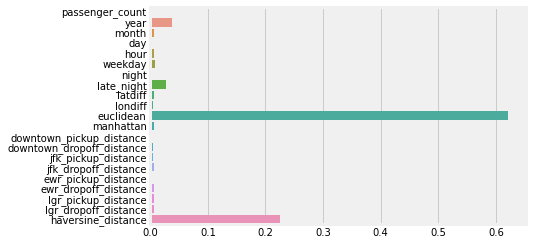

In [52]:
# let's plot feature_importance again and check if there is any difference or not.
sns.barplot(y=list(X_train[xgb_cols].columns), x=list(XGB_model.feature_importances_))

### tensorflow
* https://www.kaggle.com/dimitreoliveira/taxi-fare-prediction-with-keras-deep-learning

In [238]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers

In [239]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [248]:
fea_cols = ['passenger_count', 
            'night', 'late_night', 'euclidean',
            'manhattan', 'downtown_pickup_distance', 'downtown_dropoff_distance', 'jfk_pickup_distance', 'jfk_dropoff_distance', 
            'ewr_pickup_distance', 'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance', 'haversine_distance']

train_df  = X_train[fea_cols]
train_labels  = y_train

validation_df = X_valid[fea_cols]
validation_labels  = y_valid

In [241]:
train_df.head()

,passenger_count,night,late_night,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance,haversine_distance
692508,1,0,1,0.015957,0.018711,0.024944,0.006233,0.281166,0.293781,0.217731,0.199020,0.167271,0.185982,1.362858
141365,1,0,0,0.020864,0.029228,0.082077,0.052849,0.314510,0.318546,0.274864,0.245636,0.110138,0.139366,1.980944
247420,0,0,1,0.016691,0.023602,0.077919,0.078320,0.316715,0.293114,0.270706,0.271107,0.114296,0.113895,1.638783
710801,5,0,0,0.048131,0.064255,0.013058,0.077312,0.300758,0.323219,0.205845,0.270100,0.179157,0.114902,5.132521
901721,4,0,0,0.007671,0.009205,0.109322,0.118526,0.306309,0.312050,0.302109,0.311314,0.092690,0.098431,0.843657


In [242]:
# Scale data
scaler = sklearn.preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)
validation_df_scaled = scaler.transform(validation_df)

In [243]:
train_df_scaled[0]

array([0.16666667, 0.        , 1.        , 0.00853198, 0.00715188,
       0.00700544, 0.00172263, 0.0861982 , 0.0884767 , 0.05801318,
       0.05222437, 0.04801458, 0.05258322, 0.00765678])

#### model
* https://www.kaggle.com/dimitreoliveira/taxi-fare-prediction-with-keras-deep-learning
* https://www.tensorflow.org/tutorials/keras/regression [这个是官网上的内容]

In [244]:
# LEARNING_RATE = 0.05
# BATCH_SIZE = 64
# EPOCHS = 10

# model = Sequential()
# model.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(8, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(1))

# adam = optimizers.Adam(lr=LEARNING_RATE)
# model.compile(loss='mse', optimizer=adam, metrics=['mae'])

In [270]:
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_df))

print(normalizer.mean.numpy())

[1.6839526  0.20082663 0.37035254 0.03139226 0.04044973 0.06979401
 0.07321247 0.30331174 0.3017345  0.2607147  0.2631594  0.13287263
 0.1328493  3.0884564 ]


In [276]:
LEARNING_RATE = 0.05

def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])

    adam = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
    return model

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [277]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 14)                29        
_________________________________________________________________
dense_66 (Dense)             (None, 64)                960       
_________________________________________________________________
dense_67 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 65        
Total params: 5,214
Trainable params: 5,185
Non-trainable params: 29
_________________________________________________________________


In [278]:
%%time
history = dnn_model.fit(
    train_df, train_labels,
    validation_split=0.2,
    verbose=0, epochs=5)

Wall time: 1min 2s


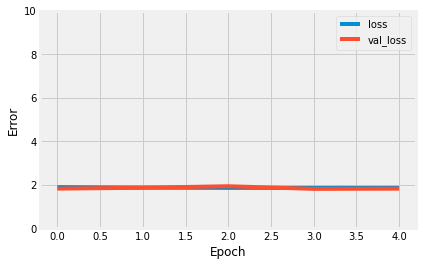

In [279]:
plot_loss(history)

Text(0, 0.5, 'Predictions')

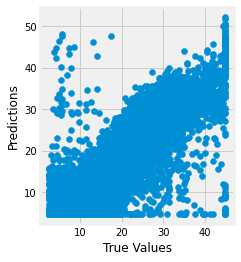

In [280]:
validation_df_pred = dnn_model.predict(validation_df).flatten()

a = plt.axes(aspect='equal')
plt.scatter(validation_labels, validation_df_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

In [282]:
model_error = np.sqrt(mean_squared_error(validation_labels, validation_df_pred))
model_error

3.0510368